### Jash Gandhi
### BE IT
### 2018140019
#### Implementation of Image Enhancement using Genetic Algorithm

#### Parameters

pop_size -> population size


num_parents -> Parents selected for mating

crossover_type -> Crossover type ( one point or two point)

mutation_rate -> Mutation rate of the genetic algorithm

crossover_rate -> Crossover rate of the genetic algorithm

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import sys
from random import randint
from numpy.random import default_rng
import random
# import time
from tqdm.notebook import tqdm_notebook
rng = default_rng()
np.random.seed(909)


### Genetic Algorithm functions

#### Creating Initial Population

In [2]:
def create_population(N,size):
    arr = []
    for _ in range(size):
        tp = [randint(1,244) for _ in range(N-2)]
        tp.extend([0,255])
        # 0 and 255 are added according to the paper
        tp.sort()
        arr.append(tp)
    return np.array(arr)

#### Fitness Function and Image generation from old and new gray levels

As mentioned in the paper,the fitness function used is

Fitness function = sum of intensities of the image x edges count



In [3]:
def create_enhanced_image(original_gray_levels,enhanced_gray_levels,img_array):
    assert(len(original_gray_levels)==len(enhanced_gray_levels)) 
    hmap={}
    for i in range(len(enhanced_gray_levels)):
        hmap[original_gray_levels[i]]=enhanced_gray_levels[i]
    # iterate through each pixel and change it to enhanced one as mentioned in paper for edge detection
    enhanced_image=np.empty(img_array.shape)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            enhanced_image[i][j]=hmap[img_array[i][j]]
            
    return enhanced_image

def count_edges(img_array):
    edges = cv2.Canny(np.uint8(img_array), threshold1=100, threshold2=200)
    edge_count = np.count_nonzero(edges)
    return edge_count

def fitness_function(population,gray_levels,img_array,freq):
    fitness=[]
    for chromosome in population:
        fitness.append(fitness_func_for_one(chromosome,gray_levels,img_array,freq))
    return np.array(fitness)
    
def fitness_func_for_one(chromosome,gray_levels,img_array,freq):
    enhanced_img_array = create_enhanced_image(gray_levels,chromosome,img_array)
    edge_count = count_edges(enhanced_img_array)
    
    intensities = sum([chromosome[i]*freq[i] for i in range(len(chromosome))])
    return np.log(np.log(intensities)) * edge_count
#     return edge_count

#### Selection

Roulette wheel selection is used in the paper


Two methods are implemented below

In [4]:
def maximum_fitness_selection(population,fitness,total_offsprings_in_each_gen):
    
    parents = np.empty((total_offsprings_in_each_gen, population.shape[1]))
    for parent_num in range(total_offsprings_in_each_gen):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999 # so that it doesnt get selected the next time
        
    return parents

def roulette_wheel_selection(population,fitness,total_offsprings_in_each_gen):
  # Computes the totallity of the population fitness
    population_fitness = sum(fitness)
    
    # Computes for each chromosome the probability 
    chromosome_probabilities = [fitness[i]/population_fitness for i,chromosome in enumerate(population)]
    
    parents = rng.choice(population,p=chromosome_probabilities,size=total_offsprings_in_each_gen,replace=False)
    
    return parents

#### Crossover

Two point and one point crossover are implemented

Paper suggests the use of two point crossover


In [5]:
def randomNumGen(limit,count):
    return np.sort(rng.choice(np.arange(limit[0],limit[1]+1),size=count,replace=False))
        

def crossover(c_type,parents,offspring_size,population):
    '''
    performing crossover between 2 parents
    parameters:
    c_type: crossover type
    parents: the parents used to create offspring
    offspring size: tuple of (genes in a chromosome,number of offsprings to be created)
    population,
    '''
    
    assert c_type=="two-point-crossover" or c_type=='single-point-crossover',"Crossover types supported are two point and one point"
    
    if c_type=="two-point-crossover":
    return two_point_crossover(parents,offspring_size,population)
    else:
        return one_point_crossover(parents,offspring_size,population)

def two_point_crossover(parents,offspring_size,population):
    
    for k in range(offspring_size[1]):
        c_point = randomNumGen((0,offspring_size[0]),2)
        parent1_idx = (2*k)%parents.shape[0]
        parent2_idx = (2*k+1)%parents.shape[0]
        
        offspring1 = np.concatenate((parents[parent1_idx][:c_point[0]],parents[parent2_idx][c_point[0]:c_point[1]],parents[parent1_idx][c_point[1]:]))
        assert(len(offspring1)==len(parents[k]))
        
        offspring2 = np.concatenate((parents[parent2_idx][:c_point[0]],parents[parent1_idx][c_point[0]:c_point[1]],parents[parent2_idx][c_point[1]:]))
        assert(len(offspring2)==len(parents[k]))
        
        population = replace_parents_with_offsprings(population,[offspring1,offspring2],[parent1_idx,parent2_idx],parents)
        
        
    return population

def one_point_crossover(parents,offspring_size,population):
    
    for k in range(offspring_size[1]):
        c_point = randomNumGen((0,offspring_size[0]),1)
        parent1_idx = (2*k)%parents.shape[0]
        parent2_idx = (2*k+1)%parents.shape[0]
        
        offspring1 = np.concatenate((parents[parent1_idx][:c_point[0]],parents[parent2_idx][c_point[0]:]))
        assert(len(offspring1)==len(parents[k]))
        
        offspring2 = np.concatenate((parents[parent2_idx][:c_point[0]],parents[parent1_idx][c_point[0]:]))
        assert(len(offspring2)==len(parents[k]))
        
        offsprings = [offspring1,offspring2]
        parent_idxs = [parent1_idx,parent2_idx]
        population = replace_parents_with_offsprings(population,offsprings,parent_idxs,parents)
                                    
    return population

def replace_parents_with_offsprings(population,offsprings,parent_idxs,parents):
    offsprings[0].sort()
    offsprings[1].sort()
    population[np.where((population==parents[0]).all(-1))[0]] = offsprings[0]
    population[np.where((population==parents[1]).all(-1))[0]] = offsprings[1]
#     for idx in parent_idxs:
#         curr_offspring = offsprings.pop(0)
#         # after crossover, they may not be sorted
#         curr_offspring.sort()
#         curr_offspring = np.reshape(curr_offspring,(1,-1))
#         ind = np.where((population==parents[idx]).all(-1))[0]
#         population[ind] = curr_offspring
    return population
    

#### Mutation

In [6]:
def mutation(mutation_rate,population):
    
    '''
    adding mutation in the current population
    randomly setting 5% of the genes of the selected chromosomes from the population
    
    the value is set randomly between the previous and next gene value(gray levels)
    '''
    
    no_of_genes = len(population[0])
    for pop_ind,chromosome in enumerate(population):
        if np.random.random()<mutation_rate:
            #do mutation
            #5% of genes are to be mutated as mentioned in the paper
            count = int(0.05*no_of_genes)
            selected_to_be_mutated =  np.sort(rng.choice(np.arange(1,no_of_genes-1),size=count,replace=False))
            # the index range is set between 1 and n-1 so that initial and final dynamic range(0,255) are not changed
            
            for index in selected_to_be_mutated:
                chromosome[index] = np.int64(random.randint(chromosome[index-1].item(),chromosome[index+1].item()))
                # a random number between previous and next is added
                
            #after mutation, the chromosome is replaced with the original one in the population
            population[pop_ind] = chromosome
            
    return population
                
        

### Traditional method of Histogram Equalization

In [7]:
def equalizeHistogram(img_array):
    gray_levels,freq = np.unique(img_array,return_counts=True)
    N = len(gray_levels)
    histogram=enumerate(freq)
    nk=[]
    pdf=[]
    cdf=[]
    final_grey_levels=[]
    tp_cdf=0
    total = sum(freq)
    for i in range(N):
        nk.append(freq[i])
        pdf.append(freq[i]/total)
        cdf.append(tp_cdf+pdf[i])
        tp_cdf=cdf[i]
        final_grey_levels.append(round((N-1)*cdf[i]))
    return create_enhanced_image(gray_levels,final_grey_levels,img_array)

### Parameters

In [8]:
pop_size = 100
num_parents = 4

crossover_rate = 0.3

mutation_rate = 0.1

num_generations = 80

crossover_type = 'two-point-crossover'

## Genetic Algorithm

In [9]:
def GA(img,pop_size,num_parents,crossover_rate,mutation_rate,crossover_type,num_generations,population):
    num_individuals = pop_size
    total_offsprings_in_each_gen = int(crossover_rate * num_individuals)
    
    img_array = np.asarray(img)
    gray_levels,freq = np.unique(img_array,return_counts=True)
    gray_levels.sort()
    N = len(gray_levels)
    new_pop = population
    for gen in tqdm_notebook(range(num_generations)):


        fitness = fitness_function(population,gray_levels,img_array,freq)
        
        parents = roulette_wheel_selection(population,fitness,total_offsprings_in_each_gen)
        
        new_pop = crossover(crossover_type,parents,(N,total_offsprings_in_each_gen),new_pop)

        new_pop  = mutation(mutation_rate,new_pop)
        
        
    print("---------------------\n\n")
    fitness = fitness_function(population,gray_levels,img_array,freq)
    max_ind = np.where(fitness==max(fitness))
    # print(max_ind)
    # max_ind = np.where(fitness==max(fitness))
    best_contrasted_img_array = new_pop[max_ind]
    
    best_contrasted_img_array = np.reshape(best_contrasted_img_array,gray_levels.shape)
    best_contrasted_img = create_enhanced_image(gray_levels,best_contrasted_img_array,img_array)
    
#     equalized = equalizeHistogram(img_array)
    
#     plotGraphs(img,best_contrasted_img,create_enhanced_image(gray_levels,population[0],img_array),equalized)
    return best_contrasted_img,max(fitness)

#### Displaying all images for visualization purposes

In [11]:
def plotGraphs(img,best_contrasted_img,checking_img,equalized):
    f, axarr = plt.subplots(2,2,figsize=(10,10))

    axarr[0,0].imshow(img, cmap='gray', vmin=0, vmax=255)
    axarr[0,0].set_title("Original image")

    axarr[0,1].imshow(best_contrasted_img, cmap='gray', vmin=0, vmax=255)
    axarr[0,1].set_title("Image generated using Genetic Algorithm")

    axarr[1,0].imshow(checking_img, cmap='gray', vmin=0, vmax=255)
    axarr[1,0].set_title("Random Image generated from initial population")

#     equalized = equalizeHistogram(img_array)
    axarr[1,1].imshow(equalized,cmap='gray',vmin=0,vmax=255)
    axarr[1,1].set_title("Histogram Equalized Image")
    
    plt.savefig(str(randint(1,100))+"_4_graphs.png")

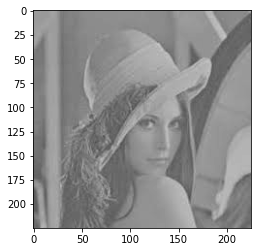

In [12]:
img = Image.open('low_contrast.jfif').convert('L')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [13]:
N = len(np.unique(np.asarray(img)))
population = create_population(N,pop_size)

In [14]:
import copy

### Genetic Algorithm Run

In [16]:
solutions = []
for c_rate in np.arange(0.1,1,0.1):
    final_img,best_fitness = GA(img,pop_size,num_parents,c_rate,mutation_rate,crossover_type,num_generations,copy.deepcopy(population))
#     evaluation(*images)
    temp_dict = {"img":final_img,"crossover_rate":c_rate,"fitness":best_fitness,"no_of_edges":count_edges(final_img)}
    solutions.append(temp_dict)

  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




In [17]:
np.save("solutions_array",np.array(solutions))

In [18]:
best_img_dict = max(solutions,key = lambda x: x['fitness'])

In [19]:
img_array = np.asarray(img)
gray_levels,freq = np.unique(img_array,return_counts=True)
gray_levels.sort()

------------------------------------


(6454, 4154, 2336)

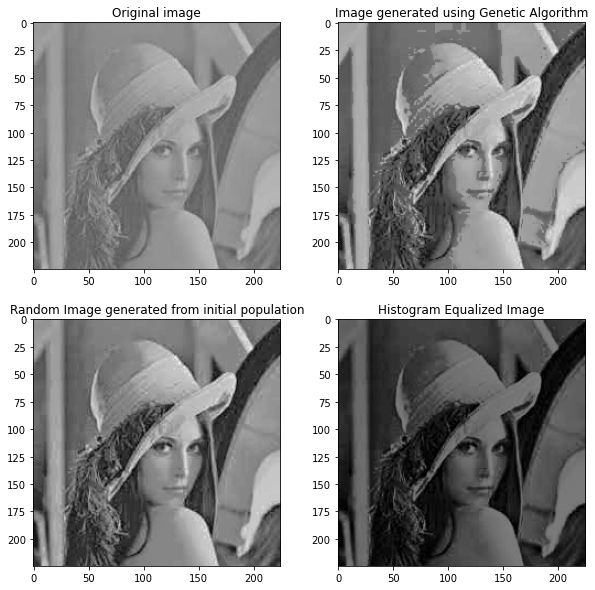

In [21]:
checking_img = create_enhanced_image(gray_levels,population[0],img_array)
best_enhanced_img = best_img_dict['img']
og_img = img
hist_equalized_img = equalizeHistogram(img_array)

plotGraphs(og_img,best_enhanced_img,checking_img,hist_equalized_img)
print("------------------------------------")
evaluation(og_img,best_enhanced_img,hist_equalized_img)

In [22]:
print("BEST CROSSOVER RATE FOUND IS:",best_img_dict['crossover_rate'])

BEST CROSSOVER RATE FOUND IS: 0.5


In [ ]:
# N = len(np.unique(np.asarray(img)))
# population = create_population(N,pop_size)
# import copy

In [29]:
solutions_mutation = []
crossover_rate = 0.3
for m_rate in np.arange(0.1,1,0.1):
    final_img,best_fitness = GA(img,pop_size,num_parents,crossover_rate,m_rate,crossover_type,num_generations,copy.deepcopy(population))
#     evaluation(*images)
    temp_dict = {"img":final_img,"mutation_rate":m_rate,"fitness":best_fitness,"no_of_edges":count_edges(final_img)}
    solutions_mutation.append(temp_dict)
    

  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




  0%|          | 0/80 [00:00<?, ?it/s]

---------------------




In [30]:
np.save("solutions_array_mutation",np.array(solutions_mutation))

------------------------------------


(6607, 4154, 2336)

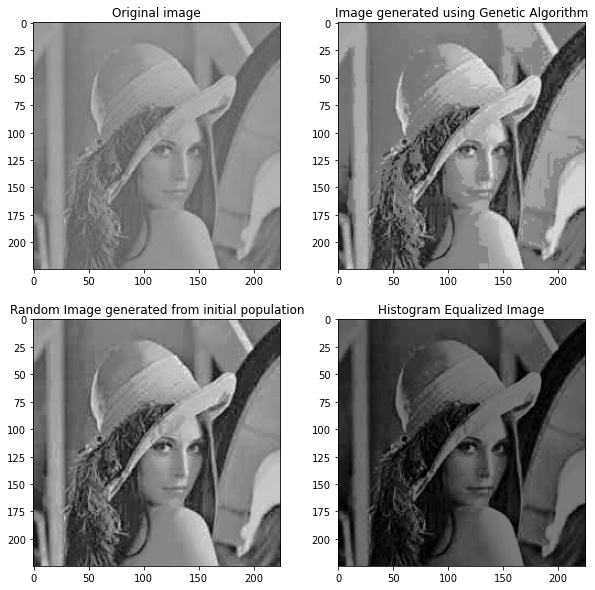

In [31]:
best_img_dict = max(solutions_mutation,key = lambda x: x['fitness'])
# checking_img = create_enhanced_image(gray_levels,population[0])
best_enhanced_img = best_img_dict['img']
og_img = img
# hist_equalized_img = equalizeHistogram(img_array)

plotGraphs(og_img,best_enhanced_img,checking_img,hist_equalized_img)
print("------------------------------------")
evaluation(og_img,best_enhanced_img,hist_equalized_img)

In [32]:
c_rate=[]
fitness = []
no_of_edges = []
for s in solutions:
    c_rate.append(s['crossover_rate'])
    fitness.append(s['fitness'])
    no_of_edges.append(s['no_of_edges'])

In [33]:
m_rate=[]
fitness = []
no_of_edges = []
for s in solutions_mutation:
    m_rate.append(s['mutation_rate'])
    fitness.append(s['fitness'])
    no_of_edges.append(s['no_of_edges'])

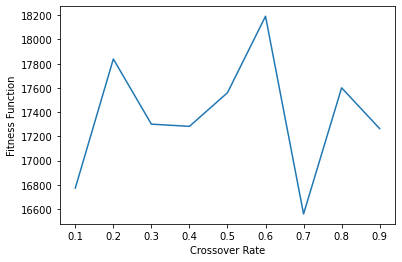

<Figure size 432x288 with 0 Axes>

In [34]:
plt.plot(c_rate,fitness)
# plt.legend("Crossover v/s fitness")
plt.xlabel('Crossover Rate')
plt.ylabel('Fitness Function')
plt.show()
plt.savefig('crossover_fitness.png')
# plt.plot(no_of_edges,c_rate,legend="Crossover v/s No of edges in a")

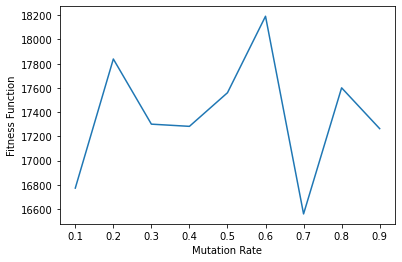

<Figure size 432x288 with 0 Axes>

In [36]:
plt.plot(m_rate,fitness)
plt.xlabel('Mutation Rate')
plt.ylabel('Fitness Function')
plt.show()
plt.savefig('mutation_fitness.png')

### Evaluation
#### Edge count between image enhanced by GA and HE

In [15]:
def evaluation(img,best_contrasted_img,equalized):
    return count_edges(best_contrasted_img),count_edges(equalized),count_edges(img)
#     print("Edges in best img,histogram equalized and og image respectively are\n",count_edges(best_contrasted_img),count_edges(equalized),count_edges(img))

In [38]:
def GA_with_fitness_graph(img,pop_size,num_parents,crossover_rate,mutation_rate,crossover_type,num_generations,population):
    num_individuals = pop_size
    total_offsprings_in_each_gen = int(crossover_rate * num_individuals)
    
    all_fitness_vals=[]
    img_array = np.asarray(img)
    gray_levels,freq = np.unique(img_array,return_counts=True)
    gray_levels.sort()
    N = len(gray_levels)
    new_pop = population
    for gen in tqdm_notebook(range(num_generations)):


        fitness = fitness_function(population,gray_levels,img_array,freq)
        
        all_fitness_vals.append(max(fitness))
        
        
        parents = roulette_wheel_selection(population,fitness,total_offsprings_in_each_gen)
        
        new_pop = crossover(crossover_type,parents,(N,total_offsprings_in_each_gen),new_pop)

        new_pop  = mutation(mutation_rate,new_pop)
        
    plt.plot([i for i in range(num_generations)],all_fitness_vals)
    plt.xlabel("Generations")
    plt.ylabel("Fitness Values")
    plt.show()
    plt.savefig("generations_fitness.png")
    print("---------------------\n\n")
    fitness = fitness_function(population,gray_levels,img_array,freq)
    max_ind = np.where(fitness==max(fitness))
    # print(max_ind)
    # max_ind = np.where(fitness==max(fitness))
    best_contrasted_img_array = new_pop[max_ind]
    
    best_contrasted_img_array = np.reshape(best_contrasted_img_array,gray_levels.shape)
    best_contrasted_img = create_enhanced_image(gray_levels,best_contrasted_img_array,img_array)
    
#     equalized = equalizeHistogram(img_array)
    
#     plotGraphs(img,best_contrasted_img,create_enhanced_image(gray_levels,population[0],img_array),equalized)
    return best_contrasted_img,max(fitness),all_fitness_vals

  0%|          | 0/100 [00:00<?, ?it/s]

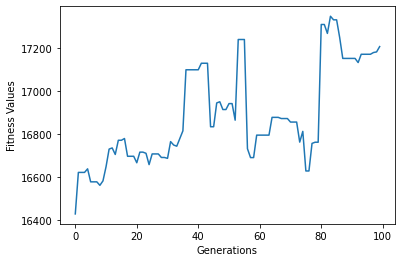

---------------------




<Figure size 432x288 with 0 Axes>

In [39]:
crossover_rate = max(solutions,key = lambda x: x['fitness'])['crossover_rate']
mutation_rate = max(solutions_mutation,key = lambda x: x['fitness'])['mutation_rate']
crossover_type = 'single-point-crossover'
num_generations = 100
best_img_poss,fitness,all_fitness_vals = GA_with_fitness_graph(img,pop_size,num_parents,crossover_rate,mutation_rate,crossover_type,num_generations,population)
# evaluation(og_img,best_img_poss,hist_equalized_img)

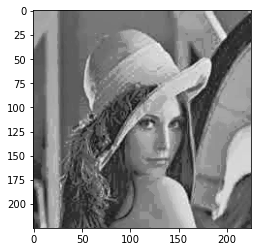

In [40]:
plt.imshow(best_img_poss,cmap='gray', vmin=0, vmax=255)

In [44]:
print(count_edges(best_img_poss))

6215


#### Conclusion
Image contrast has been enhanced by the use of genetic algorithm and it is compared with histogram equalization method and proved to be better.
The results of the paper could be replicated in this implementation.

### References:

1. Research Paper: https://ieeexplore.ieee.org/abstract/document/5190563

2. Genetic Algorithm: https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6 